In [1]:
import pathlib, sys, os, random, time
import torch
torch.cuda.empty_cache()
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

/home/mdi220/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mdi220/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/mdi220/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# mounting google drive
collaboratory = False

if collaboratory:
    from google.colab import drive
    drive.mount('/gdrive')
    # !ln -s "/gdrive/Shareddrives/HSC_project/HSC_ML" "/content/HSC_ML"
    os.chdir("/gdrive/Shareddrives/HSC_project/HSC_ML")
else: 
    print('Running on local systems, if running on collaboratory please change above')

print(os.listdir())
# print(os.getcwd())
#!unzip ./HSC_ML/Output/TBCells_crops.zip -d ./HSC_ML/Output/

if collaboratory:
  image_folder = "./Output/"
else:
  image_folder = "../../Output/TBCells_crops/Train_data/"
trained_weights = image_folder[:-11]+"Results/Latest_Weight_AE_unet/"


if not os.path.exists(trained_weights):
        os.makedirs(trained_weights)

Running on local systems, if running on collaboratory please change above
['UNet.py', 'Note.txt', 'CNN_AE.py', 'test copy.ipynb', 'CNN_training.ipynb', 'CNN_auto_encoder.ipynb', '__pycache__', 'delete-files.py', 'Resnet_training.ipynb', 'CNN_training_test.ipynb', 'CNN_auto_encoder_test.ipynb', 'CNN_auto_encoder_backup.ipynb', 'elastic_deform.py']


# Elastic deformation

In [ ]:
from elastic_deform import elastic_deform

# augment_instance = elastic_deform(image_folder)
# augment_instance.augment()
# augment_instance.copy_aug()

# spliting dataset into train and test

In [3]:
im_size = 256
train_transform = transforms.Compose([
    transforms.Resize((im_size,im_size)),
    # transforms.Resize((572,572)),
    transforms.ColorJitter(brightness = 0.25, contrast=0.25),
    #transforms.RandomRotation(90),
    transforms.RandomRotation(degrees=(90, 90)),
    transforms.RandomRotation(degrees=(270, 270)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),

])

val_transform = transforms.Compose([transforms.Resize((im_size,im_size)),transforms.ToTensor()])

In [4]:
import torch
from torchvision import datasets

# add path of images https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path



import sklearn.model_selection

dataset = ImageFolderWithPaths(image_folder, transform=train_transform)
print(dataset.class_to_idx)
train_indices, val_indices = sklearn.model_selection.train_test_split(
                    list(range(dataset.__len__())),          # list of indices of dataset
                    stratify = dataset.targets,                 # for stratify sampling the data due to the unblanced dataset
                    random_state = 42,
                    test_size=.25                               #represent the proportion of the dataset to include in the train split.
                    )



# subsetting the dataset into train and test
training_data = torch.utils.data.Subset(dataset, train_indices)
test_data = torch.utils.data.Subset(dataset, val_indices) 

print(f"Length of dataset:" )
print(f" {'Train dataset':<12}   \u2502   {'Test data':>12} ")
print(f" {len(training_data):<12}    \u2502   {len(test_data) :>12}")

{'BCells_Old_crops': 0, 'TCells_Old_crops': 1}
Length of dataset:
 Train dataset   │      Test data 
 49116           │          16372


# Iterating and Visualizing the Dataset

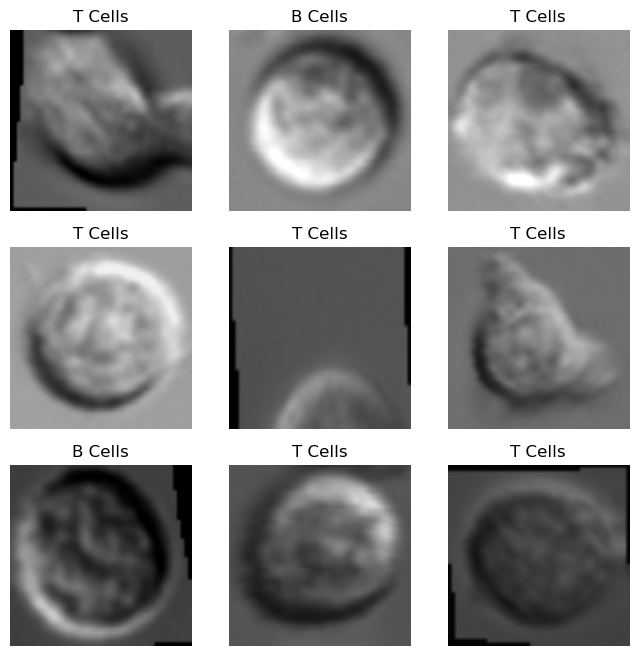

In [5]:
labels_map = {
    0: "B Cells",
    1: "T Cells",
    #2: "T8 Cells",

}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label, _ = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1,2,0), cmap="gray") 
plt.show()

In [6]:

batch_size = 64

# setting sampler weight
y_train_indices = training_data.indices
y_train = [dataset.targets[i] for i in y_train_indices]
class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True) 


# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size= batch_size,sampler = sampler, pin_memory=True, )
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=True)

for X, y, _ in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 3, 256, 256])
Shape of y:  torch.Size([64]) torch.int64


# Training the model

In [7]:
from CNN_AE import CNN_AE


In [ ]:

class CNN_encoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        
        self.encoder_1 = enc_block(in_features, 16, kernel_size=3, padding=1)
        self.encoder_pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.encoder_2 = enc_block(16, 32, kernel_size=3, padding=1)
        self.encoder_pool2 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.encoder_3 = enc_block(32, 64, kernel_size=3, padding=1)
        self.encoder_pool3 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.encoder_lin = nn.Sequential(   
            nn.Flatten(start_dim=1, ),
            #each Maxpool make the images into half. 
            # so after the Maxpool image size become 64 ==> 32 ==>16 ==> 8
            nn.Linear(8*8*64, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )
 

    def forward(self, x):
        x            = self.encoder_1(x)
        x, indices_1 = self.encoder_pool1(x)
        x            = self.encoder_2(x)
        x, indices_2 = self.encoder_pool2(x)
        x            = self.encoder_3(x)
        x, indices_3 = self.encoder_pool3(x)
        x            = self.encoder_lin(x)
        return x, indices_1, indices_2, indices_3



class CNN_decoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(n_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 8*8*64),
            nn.ReLU(),
            nn.Unflatten(1, unflattened_size= (64, 8, 8))
        )
        
        self.mx_pool_1 = nn.MaxUnpool2d(2, stride=2)
        self.decoder_1 = dec_block(64, 32, kernel_size=3, padding=1)
        
        self.mx_pool_2 = nn.MaxUnpool2d(2, stride=2)
        self.decoder_2 = dec_block(32, 16, kernel_size=3, padding=1)
        
        self.mx_pool_3 = nn.MaxUnpool2d(2, stride=2)
        self.decoder_3 = dec_block(16, in_features, kernel_size=3, padding=1)
        
        


    def forward(self, x, indices_1, indices_2, indices_3):

        x  = self.decoder_lin(x)
        x  = self.mx_pool_1 (x,  indices_3)
        x  = self.decoder_1(x)
        x  = self.mx_pool_2 (x,  indices_2)
        x  = self.decoder_2(x)
        x  = self.mx_pool_3 (x,  indices_1)
        x  = self.decoder_3(x)
        return x
    
    
    
class CNN_AE(nn.Module):
    
    def __init__(self, in_channels=3, n_classes=50, *args, **kwargs):
        super().__init__()
        self.encoder = CNN_encoder(in_channels, n_classes = 50, *args, **kwargs)
        self.decoder = CNN_decoder(in_channels, n_classes = 50, *args, **kwargs)
        
    def forward(self, x):
        x, indices_1, indices_2, indices_3 = self.encoder(x)
        x = self.decoder(x, indices_1, indices_2, indices_3)
        return x

In [8]:
# defining the model

import torchvision.models as models
from torchsummary import summary

DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print("Cuda acceleration enabled!" if torch.cuda.is_available() else 'Running on CPU')



def get_model(model_saved_path=None, input_shape = None):
    # initializing model
    model = CNN_AE()
    if model_saved_path:
        print("loading Model from saved weight")
        model.load_state_dict(torch.load(model_saved_path))
        model.eval()
        
    else:
        model.eval()
        print("Building Model from scratch")
        
    if input_shape:
        print(summary(model, input_shape))
    
    # using gpu
    model = model.cuda() if torch.cuda.is_available() else model
    return model


@torch.no_grad()
def validation(model, train_dataloader, loss_fn):
    losses = []
    model.eval()
    for image, __, _ in train_dataloader:
        image = image.to(DEVICE)
        image_croped   = torchvision.transforms.CenterCrop([68, 68])(image)
        output = model(image)
        loss = loss_fn(output, image_croped)
        losses.append(loss.item())
        
    return np.array(losses).mean()


def loss_fn(y_pred, y_true):
    bce_fn = nn.MSELoss()
    loss = bce_fn(y_pred, y_true)
    return loss


### Table for results
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m | Save status
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}' + '\t' + '\u2502 {}'


Cuda acceleration enabled!


In [9]:
# loading the model

trained_model_PATH = trained_weights +'TBCells.pt'
model = get_model(input_shape=(3, im_size, im_size))

model.to(DEVICE)

learning_rate = 4e-3
optimizer = torch.optim.Adam(model.parameters(), lr = 0.000001)

Building Model from scratch
Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [-1, 64, 128, 128]        --
|    └─ModuleList: 2                     []                        --
|    |    └─En_Block: 3-1                [-1, 64, 128, 128]        1,920
|    |    └─En_Block: 3-2                [-1, 128, 64, 64]         74,112
|    |    └─En_Block: 3-3                [-1, 256, 32, 32]         295,680
├─Decoder: 1-2                           [-1, 128, 64, 64]         --
|    └─ModuleList: 2                     []                        --
|    |    └─Dec_Block: 3-4               [-1, 128, 64, 64]         295,296
|    |    └─Dec_Block: 3-5               [-1, 64, 128, 128]        73,920
|    |    └─Dec_Block: 3-6               [-1, 3, 256, 256]         1,737
Total params: 742,665
Trainable params: 742,665
Non-trainable params: 0
Total mult-adds (M): 2.22
Input size (MB): 0.75
Forward/backward pass size (MB): 0.00
Params size (MB

In [ ]:
# ploting validation vs train error

def loss_plot(batch_losses,vlosses):
    fig, ax = plt.subplots(1, 1, figsize = (9, 5))

    plt.title("Train-Validation Accuracy")
    plt.plot(batch_losses, label='train')
    plt.plot(vlosses, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    ax.legend(loc='best')
    fig.tight_layout()
    plt.savefig(trained_weights + "Train_Validation_Accuracy.png", bbox_inches='tight', dpi=150)
    plt.close()

In [ ]:
EPOCHES = 350
vloss_min = np.Inf
print(header)
batch_losses = []
vlosses = []

for epoch in range(1, EPOCHES+1):
    losses = []
    start_time = time.time()
    model.train()
    for image, __, _ in train_dataloader:
        # 64 = image shape
        image = image.to(DEVICE)
        optimizer.zero_grad()
        # print(image.size())
        output = model(image)
        # 68 x 68 based on imsize
        image_croped   = torchvision.transforms.CenterCrop([68, 68])(image)
        loss = loss_fn(output, image_croped)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    vloss = validation(model, test_dataloader, loss_fn)
    
    batch_loss = np.array(losses).mean()
    batch_losses.append(batch_loss)
    
    vlosses.append(vloss)
    if vloss_min > vloss:
        vloss_min = vloss
        torch.save(model.state_dict(), trained_weights +'TBCells.pt')
        save_status = 'Yes'
        loss_plot(batch_losses,vlosses)
    else:
        save_status = 'No'
        
    print(raw_line.format(epoch, batch_loss, vloss,
                              (time.time()-start_time)/60**1, save_status))

# Reconstruct model from saved weights

In [ ]:
restart = False
if restart:
    model1 = torchvision.models.resnet50()
    model1.fc = torch.nn.Sequential(
        torch.nn.Linear(
            in_features=2048,
            out_features=1
        ),
        torch.nn.Sigmoid()
    )
    model1.load_state_dict(torch.load(trained_weights +'TBCells.pt'))

# Evaluating results

In [ ]:

# validating dataset

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import shutil

# defining hook to access output from intermidiate layer
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

# registerning the hook. different layer can be accessed by changing
# fc[3] parameter. for details 
# https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/05/27/extracting-features.html

# print(model)
model.decoder[0].register_forward_hook(get_features('feats'))


trained_model_PATH = trained_weights +'TBCells.pt'
model.load_state_dict(torch.load(trained_model_PATH))
model.eval()


y_pred = []
y_true = []
FEATS = [] # extracted feats will be saved here
# placeholder for batch features
features = {}


with torch.no_grad():
    for image, target, path in test_dataloader:
        image, target = image.to(DEVICE), target.to(DEVICE)
        outputs = model(image)
        output = (torch.max(outputs, 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        target = target.data.cpu().numpy()
        
        # not_matched = [target.index(y) for x, y in zip(y_pred, target) if y != x]
        not_matched = np.where(y_pred != target)[0]
        if not os.path.exists(trained_weights + "wrong_pred/"):
            os.makedirs(trained_weights + "wrong_pred/")
            for element in not_matched:
                shutil.copy(path[element], trained_weights + "wrong_pred/" + path[element].split("/")[-1]) 
        y_true.extend(target) # Save Truth
        FEATS.extend((features['feats'].cpu().numpy())) # Save feature
       
print(f' Feature extracted with shape: {np.array(FEATS).shape}')

In [ ]:
classes = labels_map.values()   
 
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

class_accuracy=np.mean(100*cf_matrix.diagonal()/cf_matrix.sum(1))
print(f'average acuraccy of all classes: {class_accuracy}')

# ploting 
font = {'family' : 'Arial',
        'size'   : 20}

plt.rc('font', **font)
fig, ax = plt.subplots( dpi = 150)
sn.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')
ax.set_title(f'Confusion Matrix, average acuracy: {class_accuracy :.2f}', fontsize = 15)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.xlabel('Predicted'); plt.ylabel('True');

plt.savefig(trained_weights + 'cf_matrix.png', bbox_inches='tight')

In [ ]:
# classification report

from sklearn.metrics import classification_report
import seaborn as sns

cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
df = pd.DataFrame(cls_report)
# df.drop(columns=['accuracy'])

fig, ax = plt.subplots(1, 1, figsize = (9, 5))

sns.heatmap(df.iloc[:-1, :].T, annot=True)
fig.tight_layout()
plt.savefig(trained_weights + "classification_report.png", bbox_inches='tight', dpi=150)

In [ ]:
print(np.array(FEATS).shape)

In [ ]:
# T-SNE plot

from sklearn.manifold import TSNE
from matplotlib import cm

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=0, perplexity=50, n_iter=5000)
tsne_proj = tsne.fit_transform(FEATS)
# Plot those points as a scatter plot and label them based on the pred labels

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))

for lab in range(len(labels_map)):
    indices = np.array(y_pred)==lab
    #ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.savefig(trained_weights + "T-SNE.png", bbox_inches='tight', dpi=150)

In [ ]:
#pip install keyboard
#import keyboard
#keyboard.press_and_release('command+s')

nb_name = "test.ipynb"
nb_full_path = os.path.join(os.getcwd(), nb_name)

import shutil
shutil.copyfile(nb_full_path, trained_weights  + nb_name)
